In [2]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Mounted at /content/drive


In [0]:
data_path = "/content/drive/My Drive/videos_rgb_2"
train_path = data_path + "/train/"
validation_path = data_path + "/validation/"
test_path = data_path + "/test/"

# Augmentations

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
      preprocessing_function = preprocess_input,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      brightness_range=(0.7, 1.3),
      zoom_range = 0.1,
      fill_mode='nearest')

# Validation and test sets should not be augmented
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

Using TensorFlow backend.


Generate batches of augmented image data

In [0]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        # All images will be resized to 224x224
        target_size=(224, 224),
        batch_size=128,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    batch_size=128,
    shuffle=False,
    class_mode='categorical')


test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=128,
    shuffle=False,
    class_mode='categorical')

Let's visualize some images from one training batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[[0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


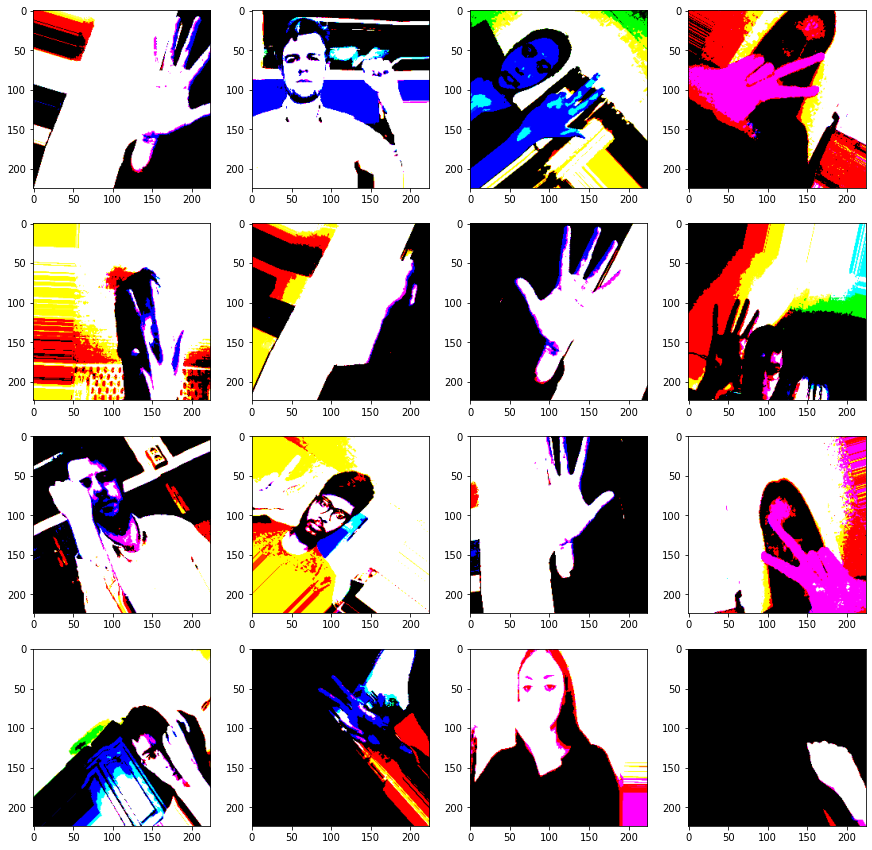

In [6]:
from matplotlib import pyplot as plt

def visualize(generator):
  images, labels = generator.next()
  plt.figure(figsize=(15,15))

  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i])

visualize(train_generator)

# Fine-tuned Resnet model

In [0]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions

In [0]:
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape = [224, 224, 3])

In [9]:
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [10]:
from keras import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D


for layer in resnet50_model.layers:
  layer.trainable = False


x = resnet50_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) 
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=resnet50_model.input, outputs=predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
checkpoint_filepath = '/content/drive/My Drive/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [0]:
from keras.optimizers import SGD
model.compile(SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])


In [0]:
num_epochs = 10

hist = model.fit(train_generator, steps_per_epoch=len(train_generator),
                    validation_data = validation_generator,
                    validation_steps = len(validation_generator), epochs = num_epochs,
                    callbacks = [model_checkpoint_callback], workers = 8)

# Visualize training history

In [0]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('acc_tf.png', bbox_inches='tight')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss_tf.png', bbox_inches='tight')
plt.show()

# Confusion matrix

In [0]:
model.load_weights("/content/drive/My Drive/checkpoint")

In [0]:
validation_generator.reset()
test_generator.reset()
predictions_val = model.predict_generator(validation_generator, steps = len(validation_generator), verbose = 0)
predictions_test = model.predict_generator(test_generator, steps = len(test_generator), verbose = 0)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import itertools


outputs_val = predictions_val.argmax(axis=-1)
outputs_test = predictions_test.argmax(axis=-1)

cm_val = confusion_matrix(validation_generator.classes, outputs_val)
cm_test = confusion_matrix(test_generator.classes, outputs_test)
cm_val

array([[297,   1,   0,   0,   0,   0],
       [  0, 302,   0,   0,   0,   0],
       [  0,   0, 383,   0,   0,   0],
       [  0,   0, 365,   0,   4,   0],
       [  0,   0, 229,   0,   7,   0],
       [  0,   0,  35,   0,  12, 222]])

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix_resnet_val_new.png', bbox_inches='tight')

In [0]:
cm_plot_labels = ['fist dorsal', 'fist palm', 'open dorsal',
                  'open palm', 'three fingers dorsal', 'three fingers palm']

plot_confusion_matrix(cm_val, cm_plot_labels, title='Confusion Matrix')